In [1]:
%reload_kedro

2020-06-08 14:38:54,101 - root - INFO - ** Kedro project Immunization Drop-outs
2020-06-08 14:38:54,101 - root - INFO - Defined global variable `context` and `catalog`


In [2]:
dfl = catalog.load("label_table")

2020-06-08 14:38:54,106 - kedro.io.data_catalog - INFO - Loading data from `label_table` (CSVDataSet)...


In [3]:
dfl.head()

,pat_id,facility,region,gender,first_vaccine,enrollment_age,exit_age,opv_by_4mths,opv_by_6mths,dtp_by_4mths,dtp_by_6mths,label
0,1,51.0,Ghanzi,f,OPV,1,23,2,4,1,3,low
1,2,89.0,Chobe,f,OPV,0,0,1,1,0,0,high
2,3,161.0,Central,m,OPV,0,6,2,2,1,1,high
3,4,168.0,Central,f,OPV,6,34,1,2,1,1,high
4,5,183.0,Central,m,OPV,2,20,3,4,2,2,low


In [4]:
dfl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45675 entries, 0 to 45674
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pat_id          45675 non-null  int64  
 1   facility        45675 non-null  float64
 2   region          45675 non-null  object 
 3   gender          45675 non-null  object 
 4   first_vaccine   45675 non-null  object 
 5   enrollment_age  45675 non-null  int64  
 6   exit_age        45675 non-null  int64  
 7   opv_by_4mths    45675 non-null  int64  
 8   opv_by_6mths    45675 non-null  int64  
 9   dtp_by_4mths    45675 non-null  int64  
 10  dtp_by_6mths    45675 non-null  int64  
 11  label           45675 non-null  object 
dtypes: float64(1), int64(7), object(4)
memory usage: 4.2+ MB


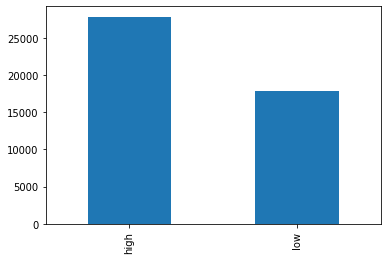

In [5]:
dfl['label'].value_counts().plot(kind='bar')

In [6]:
dfl['label'].value_counts()

high    27814
low     17861
Name: label, dtype: int64

## Encoding Categorical Data

Cast categorical data from object type to category.

In [7]:
def cast2category(df):
    """
    Cast categorical data from object type to category.
    """
    df['region'] = df['region'].astype('category')
    df['gender'] = df['gender'].astype('category')
    df['first_vaccine'] = df['first_vaccine'].astype('category')
    df['label'] = df['label'].astype('category')
    return df

In [8]:
dfl = cast2category(dfl)
dfl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45675 entries, 0 to 45674
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   pat_id          45675 non-null  int64   
 1   facility        45675 non-null  float64 
 2   region          45675 non-null  category
 3   gender          45675 non-null  category
 4   first_vaccine   45675 non-null  category
 5   enrollment_age  45675 non-null  int64   
 6   exit_age        45675 non-null  int64   
 7   opv_by_4mths    45675 non-null  int64   
 8   opv_by_6mths    45675 non-null  int64   
 9   dtp_by_4mths    45675 non-null  int64   
 10  dtp_by_6mths    45675 non-null  int64   
 11  label           45675 non-null  category
dtypes: category(4), float64(1), int64(7)
memory usage: 3.0 MB


In [9]:
from sklearn.preprocessing import LabelEncoder

In [10]:
def encode_categories(df):
    """
    Convert each value in a column to a number.
    """
    lb_make = LabelEncoder()
    df['region_code'] = lb_make.fit_transform(df['region'])
    df['gender_code'] = lb_make.fit_transform(df['gender'])
    df['first_vaccine_code'] = lb_make.fit_transform(df['first_vaccine'])
    df['label_code'] = lb_make.fit_transform(df['label'])
    return df

In [11]:
dfl = encode_categories(dfl)
dfl.head()

,pat_id,facility,region,gender,first_vaccine,enrollment_age,exit_age,opv_by_4mths,opv_by_6mths,dtp_by_4mths,dtp_by_6mths,label,region_code,gender_code,first_vaccine_code,label_code
0,1,51.0,Ghanzi,f,OPV,1,23,2,4,1,3,low,4,0,1,1
1,2,89.0,Chobe,f,OPV,0,0,1,1,0,0,high,1,0,1,0
2,3,161.0,Central,m,OPV,0,6,2,2,1,1,high,0,1,1,0
3,4,168.0,Central,f,OPV,6,34,1,2,1,1,high,0,0,1,0
4,5,183.0,Central,m,OPV,2,20,3,4,2,2,low,0,1,1,1


In [12]:
def model_input_table(df):
    """
    Create table for the model training.
    """
    df = df[['facility', 'first_vaccine_code', 'gender_code', 'region_code', 'dtp_by_4mths',
            'opv_by_4mths', 'enrollment_age', 'label_code']]
    return df

In [13]:
dfl = model_input_table(dfl)
dfl.head()

,facility,first_vaccine_code,gender_code,region_code,dtp_by_4mths,opv_by_4mths,enrollment_age,label_code
0,51.0,1,0,4,1,2,1,1
1,89.0,1,0,1,0,1,0,0
2,161.0,1,1,0,1,2,0,0
3,168.0,1,0,0,1,1,6,0
4,183.0,1,1,0,2,3,2,1


In [14]:
def create_model_table(label_table):
    """
    Create table for the model training.
    """
    df = encode_categories(label_table)
    return model_input_table(df)

In [15]:
import logging
from typing import Dict, List

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [16]:
def split_data(data: pd.DataFrame, parameters: Dict) -> List:
    """
    Splits data into training and test sets.
    """
    X = data[
        [
            'facility', 
            'first_vaccine_code', 
            'gender_code', 
            'region_code', 
            'dtp_by_4mths',
            'opv_by_4mths', 
            'enrollment_age',
        ]
    ].values
    y = data["label_code"].values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=parameters["test_size"], random_state=parameters["random_state"]
    )

    return [X_train, X_test, y_train, y_test]

In [17]:
params = {"test_size": 0.2, "random_state": 3}
[X_train, X_test, y_train, y_test] = split_data(dfl, params)